# Práctica 7
## Entrenando un detector
<ul>
<li>Nikhil Chandru Durgadas Chellaram</li>
<li>Raúl Mateus Sánchez</li>
</ul>

Para comprobar el desarrollo de la práctica: https://github.com/raulmat19/Vision-por-Computador/tree/main/Practica-7

#Paquetes necesarios

In [1]:
import cv2
import pytesseract
import glob
import os
import matplotlib.pyplot as plt
import shutil

El objetico de esta práctica es emplear _YOLOv7_ como detector, siendo para ello necesario ser entrenado para conseguir detecciones acorde a nuestra idea. Esta es señales de tráfico. Obviamente, por tiempo y recursos, se ha limitado a señales de stop, límites de velocidad, pasos de peatones y alguna más.

El trabajo realizado consiste en entrenar el detector _YOLOv7_ mediante un dataset obtenido en la red: https://www.kaggle.com/andrewmvd/road-sign-detection?select=images, y ajustado a nuestra necesidad así como se configura los parámetros pertinentes para conseguir una serie de resultados más que positivos, visualizables en [training-results](training-results/results.png) así como más detalles como la ejecución del entrenamiento en el fichero [results.txt](training-results/results.txt) y en las gráficas de la misma carpeta.

Para ajustar el dataset, de las 800+ imágenes del dataset, hemos seleccionado 115 inicialmente, descartando dos imágenes por motivos de formato. Posteriormente, mediante la herramienta _Roboflow_, hemos subido las imágenes y realizado el _labelling_ gracias a las facilidades de esta herramienta. A continuación, _Roboflow_ permite aumentar el tamaño del dataset hasta 3 veces el número de imágenes en el plan gratuito mediante opciones como introducir imágenes del dataset en blanco y negro, con saturación, invertidas, etc. En nuestro caso, hemos aplicado las siguientes:

![dataset-details](dataset-details.png)

Creado el dataset, queda descargarlo y ubicar las carpetas que genera (train, test y valid) dentro de la carpeta del _YOLOv7_, así como el fichero data.yaml dentro de /data. Ya solo quedaría ejecutar el comando para entrenar: 

<code>python train.py --device 0 --weights yolov7.pt --cfg cfg/training/yolov7.yaml --data data/traffic-signs-data.yaml --hyp data/hyp.scratch.custom.yaml --workers 8 --batch-size 8 --epochs 500 --name yolov7-traffic-signs</code>

Para poder emplear la GPU, el comando en el GitHub de la práctica 5 no funciona. En cambio, el siguiente sí funciona (al menos en nuestro caso):

<code>conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia</code>

Una vez entrenado el detector con unos resultados aceptables en un tiempo récord (gracias a la experiencia de la práctica 5), obtenemos un archivo con los mejores "pesos" (_weights_), llamado best.pt, el cual emplearemos a partir de ahora para detectar señales de tráfico, el cual se cambia el nombre a traffic-signs.pt, localizado en este repositorio

A partir de aquí, añadimos al repo imágenes que no se hayan usado para entrenar al detector (para no hacer trampa) y se modifica el detector, en su fichero detect.py, para que guarde como imagen las distintas detecciones en la carpeta (licenses-plates-detected) y posteriormente sean tratadas para que el reconocedor de texto pueda sacar la matrícula. El fichero detect.py también se incluye en el repositorio, cuya idea modificación proviene de: https://github.com/RizwanMunawar/yolov7-object-cropping/blob/main/detect_and_crop.py

En primer lugar, se realiza una pequeña muestra del detector. Para ello, lo probaremos con tres imágenes y tres vídeos y veremos sus resultados. 

# IMAGEN

In [2]:
# Limpieza de almacenamiento
shutil.rmtree('runs/', ignore_errors=True)
shutil.rmtree('traffic-signs-detected/', ignore_errors=True)

In [3]:
# Los resultados se guardan en la carpeta runs/detect/exp (la última carpeta), y las matrículas en la carpeta license-plates-detected
!python detect.py --weights traffic-signs.pt --conf 0.55 --source images\ --save-txt --device 0

## En caso de no tener GPU o no poder usarla
# !python detect.py --weights traffic.signs.pt --conf 0.55 --source images\ --save-txt --device cpu

## En caso de que de problemas ambos comandos
## La ruta es orientativa, debería ser la ruta donde cada uno tenga instalado YOLOv7
# !python C:/Users/<usuario>/anaconda3/envs/yolov7 detect.py --weights traffic.signs.pt --conf 0.55 --source images\ --save-txt --device cpu

Namespace(weights=['traffic-signs.pt'], source='images\\', img_size=640, conf_thres=0.55, iou_thres=0.45, device='0', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 Traffic-signs, Done. (12.0ms) Inference, (24.5ms) NMS
 The image with the result is saved in: runs\detect\exp\road141.jpg
1 Traffic-signs, Done. (11.5ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp\road17.jpg
2 Traffic-signss, Done. (12.0ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp\road261.jpg
2 Traffic-signss, Done. (11.0ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp\road266.jpg
2 

YOLOR  v0.1-115-g072f76c torch 1.13.0 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191.5MB)

c:\Users\rauln\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


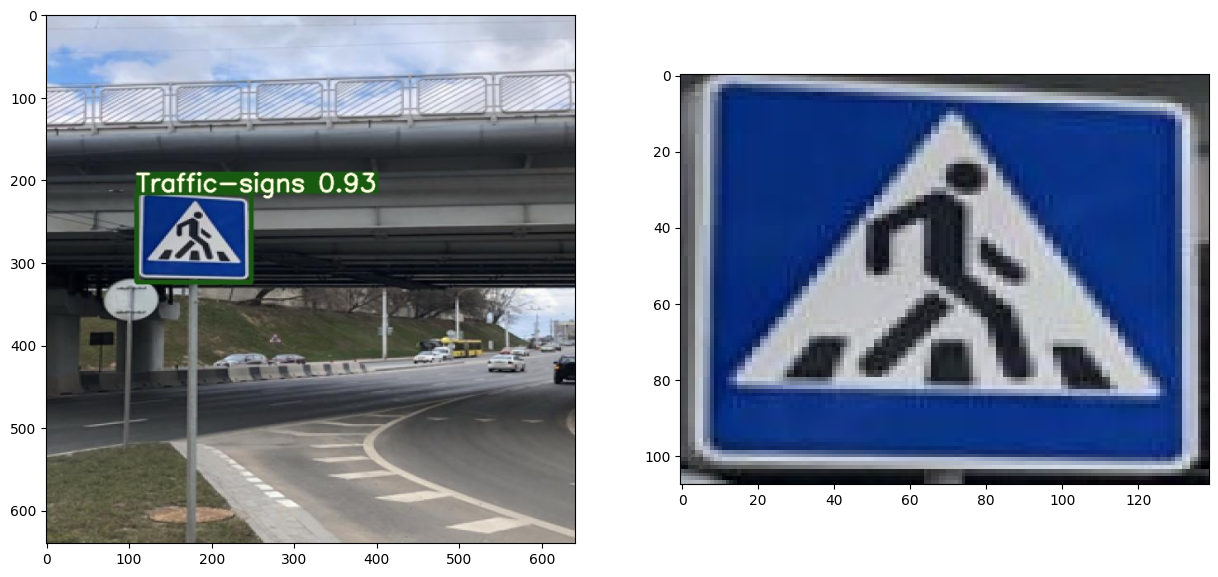

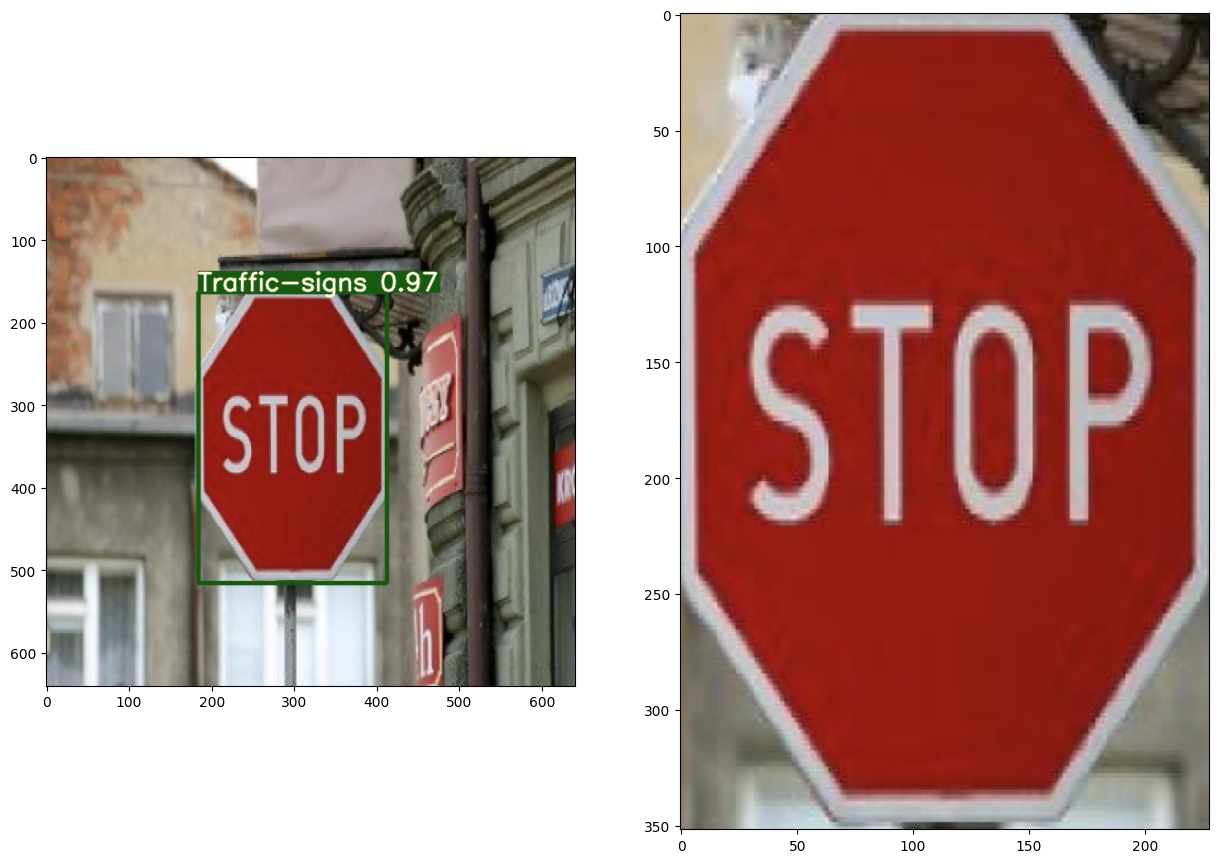

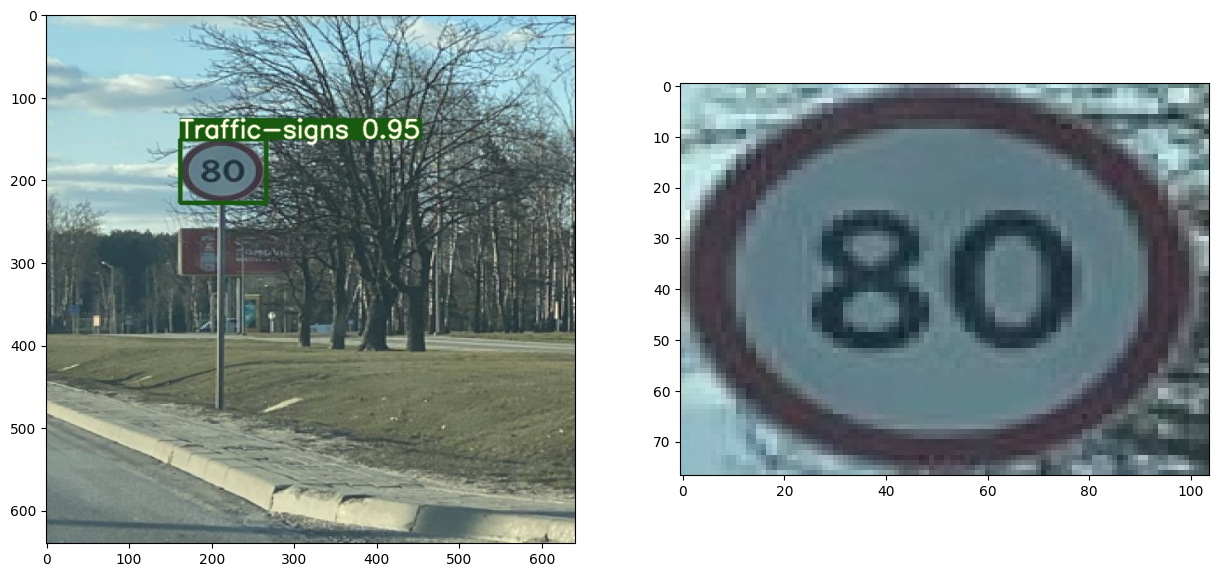

In [4]:
# Visualización de resultados
# Aunque se han generado más de tres imágenes al procesar toda la carpeta images/, solo se muestran tres así como la detección de las señales.
# Basado en un criterio totalmente aleatorio, mostramos la primera, segunda y última imagen

files = ['road17.jpg', 'road67.jpg', 'road604.jpg']
for image in files:
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    imgPath = "runs/detect/exp/" + image
    img = cv2.imread(imgPath)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.subplot(1, 2, 2)
    imgPath = "traffic-signs-detected/" + image
    img = cv2.imread(imgPath)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show


Como se puede ver, aun configurado con una confianza superior al 0.55, un porcentaje que realmente podría ser aumentado pero se considera suficiente si lo comparamos con detecciones hechas por la comunidad, en general por debajo del 0.50. En este caso, detecta las señales de tráfico sin ningún problema, pudiendo ser visualizados los resultados en la carpeta _runs/detect/exp/_ y las detecciones concretas en la carpeta _traffic-signs-detected/_

# VÍDEO

In [5]:
from IPython.display import Video
from base64 import b64encode

In [6]:
def video_detection():

    shutil.rmtree('runs/', ignore_errors=True)
    !python detect.py --weights traffic-signs.pt --conf 0.60 --source videos/ --device 0

    # No se recomienda hacerlo por CPU, debajo se especifica una celda para visualizar las detecciones en los
    # vídeos ya tratados por nosotros y que se encuentran en este repo
    #!python detect.py --weights yolov7-license-plates.pt --conf 0.5 --source videos\ --device cpu

    list_of_files = glob.glob('runs\detect\*') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    latest_file += "\\*"
    list_of_files = glob.glob(latest_file) # * means all if need specific format then *.csv
    print(list_of_files)
    
    for file in list_of_files:

        compress_path = "detected-videos/" + os.path.basename(file)
        cap = cv2.VideoCapture(file)
        
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter(compress_path,fourcc, 59, (640,480))
        
        while True:
            ret, frame = cap.read()
            if ret == True:
                b = cv2.resize(frame,(640,480),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
                out.write(b)
            else:
                break
        
        cap.release()
        out.release()
        cv2.destroyAllWindows()

In [7]:
# Para hacer la detección de matrículas en vídeos, basta con llamar a la función video_detection
# En nuestras pruebas, la ejecución puede llevar hasta 1 min, se debe tener paciencia
video_detection()

Namespace(weights=['traffic-signs.pt'], source='videos/', img_size=640, conf_thres=0.6, iou_thres=0.45, device='0', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/3 (1/485) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Computador\Practica-7\videos\video1.mp4: Done. (12.0ms) Inference, (0.0ms) NMS
video 1/3 (2/485) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Computador\Practica-7\videos\video1.mp4: Done. (12.0ms) Inference, (1.0ms) NMS
video 1/3 (3/485) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Computador\Practica-7\videos\video1.mp4: Done. (13.0ms) Inference, (0.0ms) NMS
video 1/3 (4/485) d:

YOLOR  v0.1-115-g072f76c torch 1.13.0 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191.5MB)

c:\Users\rauln\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


Para la visualización de los vídeos, saldrán tres ventanas donde se mostrará la detección. El vídeo, aunque termine, ocupará la ventana hasta que el usuario presione ESC y pase al siguiente vídeo

In [8]:
# Visualización de resultados en vídeo
list_of_files = glob.glob('detected-videos\*') # * means all if need specific format then *.csv

for file in list_of_files:
    cap = cv2.VideoCapture(file)
    while True:
        ret, frame = cap.read()
        if ret == True:
            cv2.imshow("video", frame)
        
        # Detenemos pulsando ESC
        if cv2.waitKey(20) == 27:
            break
        
    cap.release()
    cv2.destroyAllWindows()

Como resultado final, vemos que no es del todo acertado, confundiendo ruedas de coches con señales de tráfico o no detectando señales lejanas. Probablemente, aumentando la confianza podríamos filtrar esto, pero en general detecta bien las señales de tráfico básicas a media y corta distancia